In [1]:
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import sys


In [4]:
#set cuda deivce
if t.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
device = t.device(dev)

In [2]:
"""
general outline

each pixel: r, g, b, 8 for prediction, 10 for information flow (21)
input: 9 x pixel, 3x3 convoltuion which is the flattened (189)
1 dense layer: 256 relu
output: 8 sigmoid
loss: cross entrpoy

general traingin methods 
20 iters of updates the pairwise cross entry of the image

model



"""

'\ngeneral outline\n\neach pixel: r, g, b, 8 for prediction, 10 for information flow (21)\ninput: 9 x pixel, 3x3 convoltuion which is the flattened\n\n\n'

In [5]:
def perceive(state):
    sobel_y = np.array([[1,2,1],
                        [0,0,0],
                        [-1, -2, -1]])
    sobel_x = sobel_y.T
    
    grad_x = cv2.filter2D(state, -1, sobel_x)
    grad_y = cv2.filter2D(state, -1, sobel_y)
    print(state.shape, grad_x.shape, grad_y.shape)
    return np.stack([state, grad_x, grad_y])

In [6]:
def mask_to_label(mask):
    colors = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), 
             (1,0,0), (1,0,1), (1,1,0), (1,1,1)]
    color_to_index = dict(zip(colors, range(len(colors))))
    pix_to_index = lambda pixel: color_to_index.get(tuple([p.item() for p in pixel]))
    label_mask = t.zeros(len(colors), mask.shape[1], mask.shape[2])
    for i in range(mask.shape[1]):
        for j in range(mask.shape[2]):
            index = pix_to_index(mask[:,i,j])
            if index == None:
                print(mask[:,i,j])
            label_mask[index, i, j] = 1
    return label_mask
            

In [7]:
def init_img(img):
    state = t.zeros(27, 128,128)
    return t.cat((img, state))

In [8]:
def pred_to_mask(pred):
    colors = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), 
             (1,0,0), (1,0,1), (1,1,0), (1,1,1)]
    colors = np.array(colors)
    return colors[pred.argmax(dim=0)] * 255

In [9]:
class RCN(nn.Module):
    '''
    model for recurrent convoltion network
    '''
    
    def __init__(self, kernel_amount, channels_in,
                 channels_out, prec_update):
        super(RCN, self).__init__()
        
        self.kernel_amout = kernel_amount
        self.channels_out = channels_out
        self.prec_udpate = prec_update
        self.channels_in = channels_in
        
        self.preceive = nn.Sequential(
            nn.Conv2d(channels_in, kernel_amount, 3, padding='same'),
            nn.ReLU()
        )
        
        self.chg = nn.Sequential(
            nn.Conv2d(kernel_amount, kernel_amount, 1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(kernel_amount, channels_out, 1, padding='same')
            
        )
        
        
    def update(self, x, prec_update=None):
        img, state = x[:,:3,:,:], x[:,3:,:,:]
        if prec_update == None:
            prec_update = self.prec_udpate
        ds  = self.chg.forward(self.preceive.forward(x))
        update_mask = t.rand(x.shape[-2], x.shape[-1]) <= prec_update
        ds *= update_mask
        ds = t.cat((t.zeros(1,3,128,128), ds), dim=1)
        return x + ds
    
    def classify(self, x):
        return x[:, [-i for i in range(1,9)],:, :]
        
    
        

In [10]:
class OceanDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'images')
        self.msk_dir = os.path.join(root_dir, 'masks')
        self.names = np.array([s.split('.')[0] for s in os.listdir(self.img_dir)])
        self.transform = transform
        
        
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.names[idx] + '.jpg')
        msk_path = os.path.join(self.msk_dir, self.names[idx] + '.bmp')
        img, msk = cv2.imread(img_path), cv2.imread(msk_path)
        
        #there is no image normalization thus far
        #I'm going to see how it works then come back
        
        #maybe I should be converting the mask into a w x h x label
        if self.transform: 
            img = cv2.cvtColor(cv2.resize(img, (128, 128)), cv2.COLOR_BGR2RGB)
            msk = cv2.cvtColor(cv2.resize(msk, (128, 128), interpolation=0), cv2.COLOR_BGR2RGB)
            img = self.transform(img)
            msk = self.transform(msk)
            msk = msk.round()
        return img, msk, mask_to_label(msk)
        

In [11]:
root_dir = 'data/SUIM/train'
trans = transforms.Compose([
    transforms.ToTensor()
])

od = OceanDataset(root_dir, transform=trans)

In [10]:
img, msk, msk_lb = od[1]

In [67]:
test_loader = DataLoader(od, batch_size=32, shuffle=True)

In [69]:
img, msk, msk_lb = next(iter(test_loader))

IndexError: index 33 is out of bounds for dimension 1 with size 8

In [126]:
x.shape

torch.Size([1, 30, 128, 128])

In [72]:
m = nn.Conv2d(30, 100, 3, padding='same')
y = t.rand(1,30,128,128)

In [12]:
rcn = RCN(100, 30, 27, .5)
img, msk, msk_lb = od[1]
x = init_img(img).reshape(1,30,128,128)
msk_lb = msk_lb.reshape(1,8,128,128)
loss = nn.CrossEntropyLoss()
opt = optim.Adam(rcn.parameters(), 0.0001)
t.autograd.set_detect_anomaly(True)

C:\Users\graham\anaconda3\envs\RIS\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "C:\Users\graham\anaconda3\envs\RIS\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\graham\anaconda3\envs\RIS\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\graham\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\graham\anaconda3\envs\RIS\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\graham\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 667, in start
    self.io_loop.start()
  File "C:\Users\graham\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_foreve

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

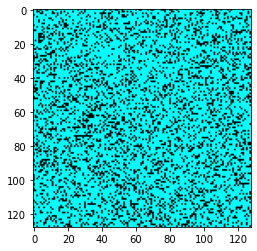

In [20]:
for i in range(1):
    x = rcn.update(x)
pred = rcn.classify(x)
plt.imshow(pred_to_mask(pred[0,:,:,:]))
cross_loss = loss(pred, msk_lb)
opt.zero_grad()
cross_loss.backward()
opt.step()
print(cross_loss)

In [240]:
msk_lb.shape

torch.Size([8, 128, 128])

In [111]:
model = nn.Sequential(
    nn.Linear(9*21, 256),
    nn.ReLU(),
    nn.Linear(256, 8),
    nn.Sigmoid()
)
loss = nn.CrossEntropyLoss()
# optim = optim.Adam(model.parameters(), lr=0.001)

sobel_y = np.array([[1,2,1],
         [0,0,0],
         [-1, -2, -1]])
sobel_x = sobel_y.T
test_img = cv2.imread('data/SUIM/train/images/d_r_18_.jpg')
test_msk = cv2.imread('data/SUIM/train/masks/w_r_136_.bmp')

In [109]:
od.names[10]

'w_r_136_'

In [8]:
os.makedirs('data/SUIM/train/images_trans', exist_ok=True)
os.makedirs('data/SUIM/train/masks_pred', exist_ok=True)
for i, name in enumerate(od.names):
    if i % 100 == 0:
        print(i)
    img, msk, msk_lb = od[i]
    t.save(img, 'data/SUIM/train/images_trans/' + name + '.pt')
    t.save(msk_lb, 'data/SUIM/train/masks_pred/' + name + '.pt')
    
    
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [9]:
i

1524

In [23]:
img, msk, msk_lb = od[3]

In [28]:
plt.imshow(img.permute(1,2,0)

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_18520/3362894173.py, line 1)

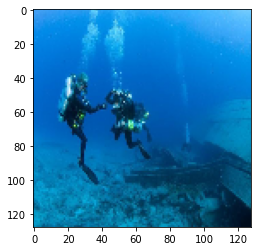

In [11]:
plt.imshow(img.permute(1,2,0))

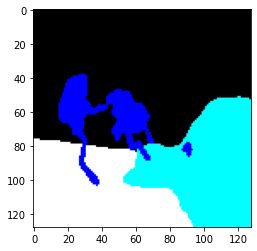

In [12]:
plt.imshow(msk.permute(1,2,0).round())

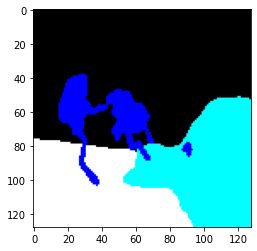

In [46]:
plt.imshow(msk.permute(1,2,0))

In [27]:
plt.imshow(test_msk)

NameError: name 'test_msk' is not defined